In [1]:
# launch simulation window
import numpy as np
from bullet_utils.env import BulletEnvWithGround
from robot_properties_solo.solo8wrapper import Solo8Config, Solo8Robot

# Create the simulation environment with a ground.
env = BulletEnvWithGround()

# Create a robot instance and add it to the simulation.
robot = Solo8Robot()
env.add_robot(robot)

# A class to simulate the DG Head with the simulator.
class SoloSimHead:
    def __init__(self, env, robot):
        self._env = env
        self._robot = robot
        
        # Define the sensor values.
        self._sensor_joint_positions = np.zeros(8)
        self._sensor_joint_velocities = np.zeros(8)
        self._sensor_slider_positions = np.zeros(4)
        
        self._sensor_slider_positions = np.zeros(4)
        
        self._sensor_imu_gyroscope = np.zeros(3)
        
        # Utility for vicon class.
        self._sensor__vicon_base_position = np.zeros(7)
        self._sensor__vicon_base_velocity = np.zeros(6)
        
        # Controls.
        self._control_ctrl_joint_torques = np.zeros(8)
        
    def read(self):
        q, dq = self._robot.get_state()
        self._sensor_joint_positions[:] = q[7:]
        self._sensor_joint_velocities[:] = dq[6:]
        
        for i, l in enumerate(['a', 'b', 'c', 'd']):
            self._sensor_slider_positions[i] = robot.get_slider_position(l)
        
        self._sensor_imu_gyroscope[:] = dq[3:6]
        
        self._sensor__vicon_base_position[:] = q[:7]
        self._sensor__vicon_base_velocity[:] = dq[:6]
        
    def write(self):
        self._robot.send_joint_command(self._control_ctrl_joint_torques)
        self._env.step(sleep=False)
        
    def get_sensor(self, sensor_name):
        return self.__dict__['_sensor_' + sensor_name]
    
    def set_control(self, control_name, value):
        self.__dict__['_control_' + control_name][:] = value
        
    def reset_state(self, q, dq):
        self._robot.reset_state(q, dq)

# Instantiate the head class and use it similar to the DG head you get
# on the real robot.
head = SoloSimHead(env, robot)


In [2]:
custom_start = np.array([0.2, 0, 0.4, 
                         0, 0, 0, 1, 
                         0.8, -1.6, 0.8, -1.6, -0.8, 1.6, -0.8, 1.6]
) # joints point inwards, towards each other

standing_start = np.array([
                    0.2, 0, 0.4, 
                    0, 0, 0, 1, 
                    0.186, -0.415, 0.185, -0.415, -0.192, 0.416, -0.192, 0.415]
)

# head.reset_state(Solo8Config.q0, Solo8Config.v0)
# head.reset_state(custom_start, Solo8Config.v0)

In [3]:
def position_error(target, joints=np.ones((8))):
#     head.read()
    return np.sum(
        np.mod(
            np.abs(
                (head.get_sensor('joint_positions') - target)*joints),
            2*np.pi)
    )


def reset(start=None):
    head.reset_state(custom_start if start is None else start, Solo8Config.v0)

    for _ in range(500):  # lay robot down
        tau = np.zeros((8))
        head.set_control('ctrl_joint_torques', tau)
        head.write()

### Constants

In [55]:
# dampening constant
D = 0.1

# motor constant
K = 5

# take single angle and "map" to target joint positions
angle_adjust = np.array([1,-2,1,-2,-1,2,-1,2]) * np.pi


In [5]:
# def move_to(target, joint_pos, joint_velocities):
#     return K*(target - joint_pos) - D * joint_velocities


def bounce_in_place_hardcoded_single_frame(up):  # single frame, have to loop over this function
    joint_pos = head.get_sensor('joint_positions')
    joint_velocities = head.get_sensor('joint_velocities')
    
    a = np.pi*np.array([1.0/6, -1.0/3]*2)
    target_up = np.concatenate((a, -1*a))
    
    a = np.pi*np.array([0.5, -1]*2)
    target_down = np.concatenate((a, -1*a))
    
    if up:
        if np.sum(np.abs(joint_pos - target_up)) < 0.5:
#             print('down now')
            up = False
    
        tau = K*(target_up - joint_pos) - D*joint_velocities
#         print(np.sum(np.abs(target_up - joint_pos)))
#         tau = np.where(np.sum(np.abs(target_up - joint_pos)) < 0.5,
#                        K*(target_up - joint_pos), 
#                        0
#                       )\
#             - D*joint_velocities
            
    else:
        if np.sum(np.mod(np.abs(joint_pos - target_down), 2*np.pi)) < 0.5:
            up = True
#             print('up now')
        tau = -D/4*joint_velocities  # let down slowly
                
    return tau, up


def bounce_in_place_hardcoded():  # multiple frames: goes up and down, call as many times as you want it to bounce
    a = np.pi*np.array([1.0/6, -1.0/3]*2)
    target_up = np.concatenate((a, -1*a))
    
    a = np.pi*np.array([0.5, -1]*2)
    target_down = np.concatenate((a, -1*a))
    
    while True:
        head.read()
        joint_pos = head.get_sensor('joint_positions')
        joint_velocities = head.get_sensor('joint_velocities')
        
        if np.sum(np.mod(np.abs(joint_pos - target_up), 2*np.pi)) < 0.5:
            break
    
        tau = K*(target_up - joint_pos) - D*joint_velocities
        
        head.set_control('ctrl_joint_torques', tau)
        head.write()
            
    while True:
        head.read()
        joint_pos = head.get_sensor('joint_positions')
        joint_velocities = head.get_sensor('joint_velocities')
        
        if np.sum(np.mod(np.abs(joint_pos - target_down), 2*np.pi)) < 0.5:
            break
            
        tau = -D/4*joint_velocities  # let down slowly
    
        head.set_control('ctrl_joint_torques', tau)
        head.write()
        
        
def stay_still():  # goes up and stays there until slider a > 0.5
    a = np.pi*np.array([1.0/6, -1.0/3]*2)
    target_up = np.concatenate((a, -1*a))
    
    a = np.pi*np.array([0.5, -1]*2)
    target_down = np.concatenate((a, -1*a))
    
    while True:  # stand up
        head.read()
        joint_pos = head.get_sensor('joint_positions')
        joint_velocities = head.get_sensor('joint_velocities')
        
        if np.sum(np.mod(np.abs(joint_pos - target_up), 2*np.pi)) < 0.5:
            break
        
        tau = K*(target_up - joint_pos) - D*joint_velocities
        
        head.set_control('ctrl_joint_torques', tau)
        head.write()
    
    
    while True:  # stay still
        head.read()
        slider_a_pos = head.get_sensor('slider_positions')[0]
        
        if slider_a_pos > 0.5: # don't move until slider > 0.5
            break
            
    
    while True:  # get down
        head.read()
        joint_pos = head.get_sensor('joint_positions')
        joint_velocities = head.get_sensor('joint_velocities')
        
        if np.sum(np.mod(np.abs(joint_pos - target_down), 2*np.pi)) < 0.5:
            break
            
        tau = -D/4*joint_velocities  # let down slowly
    
        head.set_control('ctrl_joint_torques', tau)
        head.write()

        
def move_with_slider():  
    while 1:  
        head.read()
        joint_pos = head.get_sensor('joint_positions')
        joint_velocities = head.get_sensor('joint_velocities')
        slider_pos = head.get_sensor('slider_positions')
        A = slider_pos[0]
                    
#         target = np.full((8), slider_pos[0]*np.pi)
#         target[1:4:2] *= -2
#         target[5::2] *= 2
#         target[4::2] *= -1

        target = angle_adjust*A/2
            
        tau = K*(target - joint_pos) - D*joint_velocities
        
        head.set_control('ctrl_joint_torques', tau)
        head.write()


def move_leg_forward():
    a = np.pi*np.array([1/6, -1/3]*2)
    target_up = np.concatenate((a, -1*a))
    
    a = np.pi*np.array([0.5, -1]*2)

    target_down = np.concatenate((a, -1*a))
    while True:  # up
        head.read()
        joint_pos = head.get_sensor('joint_positions')
        joint_velocities = head.get_sensor('joint_velocities')
        
        if np.sum(np.abs(joint_pos - target_up)) < 0.5:
            break
        
        tau = K*(target_up - joint_pos) - D*joint_velocities
        
        head.set_control('ctrl_joint_torques', tau)
        head.write()
    
    
#     while True:  # stay still
#         head.read()
#         slider_a_pos = head.get_sensor('slider_positions')[0]
        
#         if slider_a_pos > 0.5: # don't move until slider > 0.5
#             break
            
    #     target_down = np.array(target_up, copy=True)
    #     target_down[:2] = [1/6, -1/3]
    #     print(target_down)
    while True:  # down
        head.read()
        joint_pos = head.get_sensor('joint_positions')
        joint_velocities = head.get_sensor('joint_velocities')
        slider_a_pos = head.get_sensor('slider_positions')[0]
        
        if slider_a_pos > 0.5: # manual exit
            break
        
        if np.sum(np.mod(np.abs(joint_pos - target_down), 2*np.pi)) < 0.5:
            break
        
        tau = -D/4*joint_velocities  # let down slowly
#         tau = K/10*(target_down - joint_pos) - D*joint_velocities
        # TODO
    
        head.set_control('ctrl_joint_torques', tau)
        head.write()


def bounce_in_place():
#     a = np.pi*np.array([1.0/6, -1.0/3]*2)
#     target_up = np.concatenate((a, -1*a))

    target_up = angle_adjust * 1/6
    
    head.read()    
    joint_positions = head.get_sensor('joint_positions')
    
    L = np.linspace(joint_positions, target_up, num=2000)
    
    for target in L:
        head.read()
        
        joint_positions = head.get_sensor('joint_positions')
        joint_velocities = head.get_sensor('joint_velocities')
        slider_positions = head.get_sensor('slider_positions')
        
        tau = K*(target - joint_positions) - D*joint_velocities
        
        head.set_control('ctrl_joint_torques', tau)
        head.write()
        

            
#     a = np.pi*np.array([0.4, -8]*2)
#     target_down = np.concatenate((a, -1*a))        
    target_down = angle_adjust * 0.4
    
    head.read()
    joint_positions = head.get_sensor('joint_positions')
    print(joint_positions- target_up)
    L = np.linspace(joint_positions, target_down, num=2000)
    
    for target in L:
        head.read()
        
        joint_positions = head.get_sensor('joint_positions')
        joint_velocities = head.get_sensor('joint_velocities')
        slider_positions = head.get_sensor('slider_positions')
        
        tau = K/10*(target - joint_positions) - D*joint_velocities
        
        head.set_control('ctrl_joint_torques', tau)
        head.write()

        
def walk(head):
    pass

In [7]:
reset()

for _ in range(1):
#     bounce_in_place()
    move_with_slider()
    


# for i in range(1000):
#     head.read()

#     # joint_velocities = head.get_sensor('joint_velocities')
#     slider_pos = head.get_sensor('slider_positions')[0]
#     joint_pos = head.get_sensor('joint_positions')
#     joint_velocities = head.get_sensor('joint_velocities')

#     tau = K*(slider_pos - joint_pos) - D * joint_velocities

#     head.set_control('ctrl_joint_torques', tau)
#     head.write()

KeyboardInterrupt: 

array([[ 0.172, -0.497,  0.172, -0.497, -0.172,  0.497, -0.172,  0.497]])

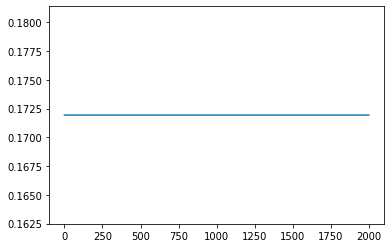

In [40]:
import matplotlib.pylab as plt

np.set_printoptions(precision=3)

plt.plot(L3[:, 0])
L2

In [63]:
reset()  # to laying down

target_up = angle_adjust * 0.02

head.read()
joint_positions = head.get_sensor('joint_positions')

L = np.linspace(joint_positions, target_up, num=2000)

for i, target in enumerate(L):
    head.read()
    joint_positions = head.get_sensor('joint_positions')
    joint_velocities = head.get_sensor('joint_velocities')

    tau = K*(target - joint_positions) - D*joint_velocities

    head.set_control('ctrl_joint_torques', tau)
    head.write()

target_down = angle_adjust * 0.2

head.read()
joint_positions = head.get_sensor('joint_positions')

L2 = np.linspace(joint_positions, target_down, num=2000)

# for target in L3[0].reshape((1, -1)):
N = 2000
for target in L2:
    head.read()
    joint_positions = head.get_sensor('joint_positions')
    joint_velocities = head.get_sensor('joint_velocities')
    
    tau = K*(target - joint_positions) - D*joint_velocities

    head.set_control('ctrl_joint_torques', tau)
    head.write()

In [ ]:
# def move_with_slider():  
reset()
np.set_printoptions(precision=3)



head.read()
joint_positions = head.get_sensor('joint_positions')
target_up = angle_adjust * head.get_sensor('slider_positions')[0]
L = np.linspace(joint_positions, target_up, num=2000)

for target in L:
    head.read()
    joint_positions = head.get_sensor('joint_positions')
    joint_velocities = head.get_sensor('joint_velocities')

    tau = K*(target - joint_positions) - D*joint_velocities

    head.set_control('ctrl_joint_torques', tau)
    head.write()

while 1:  
    head.read()
    joint_pos = head.get_sensor('joint_positions')
    joint_velocities = head.get_sensor('joint_velocities')
    slider_pos = head.get_sensor('slider_positions')
    A = slider_pos[0]
    B_t = slider_pos[1] * angle_adjust


    target = angle_adjust*A
    target[3:7] = B_t[3:7]
#     target[7:] = B_t[7:]
    
#     print(target, end='\r')
    
    tau = K*(target - joint_pos) - D*joint_velocities

    head.set_control('ctrl_joint_torques', tau)
    head.write()

In [11]:
print(L2)
print('++++')
print(L[::-1])


[[ 0.17193632 -0.49685863  0.17182172 ...  0.49686167 -0.17181286
   0.49650555]
 [ 0.17216463 -0.49723871  0.17205008 ...  0.49724175 -0.17204123
   0.49688581]
 [ 0.17239293 -0.49761879  0.17227845 ...  0.49762183 -0.1722696
   0.49726606]
 ...
 [ 0.62786192 -1.2558769   0.62786181 ...  1.25587691 -0.6278618
   1.25587655]
 [ 0.62809023 -1.25625698  0.62809017 ...  1.25625698 -0.62809016
   1.25625681]
 [ 0.62831853 -1.25663706  0.62831853 ...  1.25663706 -0.62831853
   1.25663706]]
++++
[[ 0.06283185 -0.12566371  0.06283185 ...  0.12566371 -0.06283185
   0.12566371]
 [ 0.06356587 -0.12714427  0.06356587 ...  0.12714428 -0.06356587
   0.12714427]
 [ 0.06429989 -0.12862484  0.06429988 ...  0.12862484 -0.06429988
   0.12862484]
 ...
 [ 1.52866339 -3.08235926  1.52865921 ...  3.0823604  -1.52865898
   3.08235533]
 [ 1.52939741 -3.08383983  1.52939323 ...  3.08384097 -1.52939299
   3.0838359 ]
 [ 1.53013143 -3.0853204   1.53012724 ...  3.08532154 -1.53012701
   3.08531646]]
